# Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import svm, preprocessing, tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import LinearSVR
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from regressors import stats
from sklearn.neural_network import MLPRegressor

In [2]:
%run config.ipynb

# Data

In [3]:
df = pd.DataFrame(np.load(r'../data/master_prepared.npy', allow_pickle=True))
cols = np.load(r'../data/columns_prepared.npy', allow_pickle=True)
df.columns = cols

In [4]:
drop_cols = [
    'date',
    'eligible',
    'companyid', 
    'ret_1f1',
    'ret_1f3',
    'ret_1f6',
    'ret_1f12',
    'retxs_1f1',
    'retxs_1f3',
    'retxs_1f6',
    'retxs_1f12'
]

y_col = 'ret_1f1'

# X cols are the independent variables
x_cols = [i for i in list(df.columns) if i not in drop_cols]

companies = df['companyid'].unique()
dates = df['date'].unique()

# Only use eligible data
df_eligible = df[df['eligible']==1]
X = df_eligible[x_cols].astype('float64')
y = df_eligible[y_col].astype('float64')
for col in ['companyid', 'date']:
    X.insert(0, col, df_eligible[col])


# Models Setup

In [5]:
cv = 5
scoring = 'r2'

setups_decomp = ['FF3_','FF5_','mom_','vol_', 'combined_'] # Add * for nonlinear versions
setups_pred = ['FF3','FF5','mom','vol', 'combined'] # Add * for nonlinear versions
models = {
    'OLS':LinearRegression(),
#     'Polynomial':LinearRegression(), 
    'Lasso':Lasso(alpha=2),
    'Ridge':Ridge(alpha=2),
    'Tree':DecisionTreeRegressor(max_depth=2),
#     'NN3':MLPRegressor(hidden_layer_sizes=(16, 32, 16))
}

# Cross Validation Methods

In [6]:
# Put results in a table
def kfold_test_model(model, setup, cv, scoring):
    perf = np.mean(cross_val_score(estimator=model, X=X[predictor_sets[setup]], y=y, scoring=scoring, cv=cv))
    return perf

def rolling_origin_validation(model, setup, n_splits, scoring):
    
    X_ = X[predictor_sets[setup]]
    y_ = y
    
    splits = TimeSeriesSplit(n_splits=n_splits)
    
    scorers = {'r2':r2_score, 'mean_squared_error':mean_squared_error}
    
    perf_vals = []
    
    for train_index, test_index in splits.split(X_):

        X_train = X_.loc[train_index]
        X_test = X_.loc[test_index]
        y_train = y_.loc[train_index]
        y_test = y_.loc[test_index]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        perf_val = scorers[scoring](y_test, pred)
        
        perf_vals.append(perf_val)
        
    return np.mean(perf_vals)

# Decomposition Performance

### K-Fold

In [7]:
# Linear predictors

kfold_table_decomp = pd.DataFrame(index= setups_decomp, columns=models)

for s in setups_decomp:
    for m in list(models.keys()):
#         if m != 'Linear':
#             s_ = s + '*'
#         else:
        s_ = s
            
        kfold_table_decomp[m].loc[s] = round(kfold_test_model(models[m], s_, cv, scoring), 3)

kfold_table_decomp
# kfold_table_decomp[kfold_table_decomp>0].fillna('-')

,OLS,Lasso,Ridge,Tree
FF3_,-0.031,-0.003,-0.03,-0.005
FF5_,0.038,-0.003,0.039,0.013
mom_,-0.005,-0.003,-0.005,-0.015
vol_,0.056,-0.003,0.057,0.032
combined_,0.036,-0.003,0.037,-0.001


In [8]:
# Nonlinear predictors

kfold_table_decomp = pd.DataFrame(index= setups_decomp, columns=models)

for s in setups_decomp:
    for m in list(models.keys()):

        s_ = s + '*'
            
        kfold_table_decomp[m].loc[s] = round(kfold_test_model(models[m], s_, cv, scoring), 3)

kfold_table_decomp
# kfold_table_decomp[kfold_table_decomp>0].fillna('-')

,OLS,Lasso,Ridge,Tree
FF3_,-0.117,-0.003,-0.025,-0.026
FF5_,-0.025,-0.003,0.042,0.017
mom_,-0.325,-0.003,-0.005,-0.017
vol_,-0.54,-0.003,0.054,0.029
combined_,-0.042,-0.003,0.058,0.021


### Rolling Origin Evaluation

In [9]:
# Linear Predictors

ts_table_decomp = pd.DataFrame(index= setups_decomp, columns=models.keys())

for s in setups_decomp:
    for m in list(models.keys()):

        s_ = s
            
        val = rolling_origin_validation(model=models[m], setup=s_, n_splits=cv, scoring='r2')
        ts_table_decomp[m].loc[s] = round(val, 3)

ts_table_decomp

,OLS,Lasso,Ridge,Tree
FF3_,-0.014,-0.001,-0.013,-0.068
FF5_,0.033,-0.001,0.035,-0.012
mom_,0.005,-0.001,0.006,-0.015
vol_,0.056,-0.001,0.057,0.027
combined_,0.03,-0.001,0.033,-0.009


In [10]:
# Nonlinear Predictors

ts_table_decomp = pd.DataFrame(index= setups_decomp, columns=models.keys())

for s in setups_decomp:
    for m in list(models.keys()):

        s_ = s + '*'
            
        val = rolling_origin_validation(model=models[m], setup=s_, n_splits=cv, scoring='r2')
        ts_table_decomp[m].loc[s] = round(val, 3)

ts_table_decomp

,OLS,Lasso,Ridge,Tree
FF3_,-0.042,-0.001,-0.026,-0.026
FF5_,-0.658,-0.001,0.024,0.004
mom_,-0.598,-0.001,0.009,0.006
vol_,-0.333,-0.001,0.057,0.017
combined_,-0.426,-0.001,0.057,0.008


# Prediction

### Rolling Origin

In [11]:
# Linear Predictors

ts_table_pred = pd.DataFrame(index= setups_pred, columns=models.keys())

for s in setups_pred:
    for m in list(models.keys()):

        s_ = s
            
        val = rolling_origin_validation(model=models[m], setup=s_, n_splits=cv, scoring='r2')
        ts_table_pred[m].loc[s] = round(val, 3)

ts_table_pred

,OLS,Lasso,Ridge,Tree
FF3,-0.001,-0.001,-0.001,-0.238
FF5,-0.004,-0.001,-0.004,0.004
mom,-0.005,-0.001,-0.005,-0.005
vol,-0.004,-0.001,-0.004,-0.005
combined,-0.147,-0.001,-0.143,-0.037


In [12]:
# Nonlinear Predictors

ts_table_pred = pd.DataFrame(index= setups_pred, columns=models.keys())

for s in setups_pred:
    for m in list(models.keys()):

        s_ = s + '*'
            
        val = rolling_origin_validation(model=models[m], setup=s_, n_splits=cv, scoring='r2')
        ts_table_pred[m].loc[s] = round(val, 3)

ts_table_pred

,OLS,Lasso,Ridge,Tree
FF3,-0.006,-0.001,-0.006,-0.447
FF5,-55.637,-28.475,-55.629,0.004
mom,-0.018,-0.001,-0.01,-0.005
vol,-0.032,-0.001,-0.034,-0.004
combined,-34.473,-73.019,-252.521,-0.037


# K-Fold CV Graphs

Text(0, 0.5, 'Mean Squared Error')

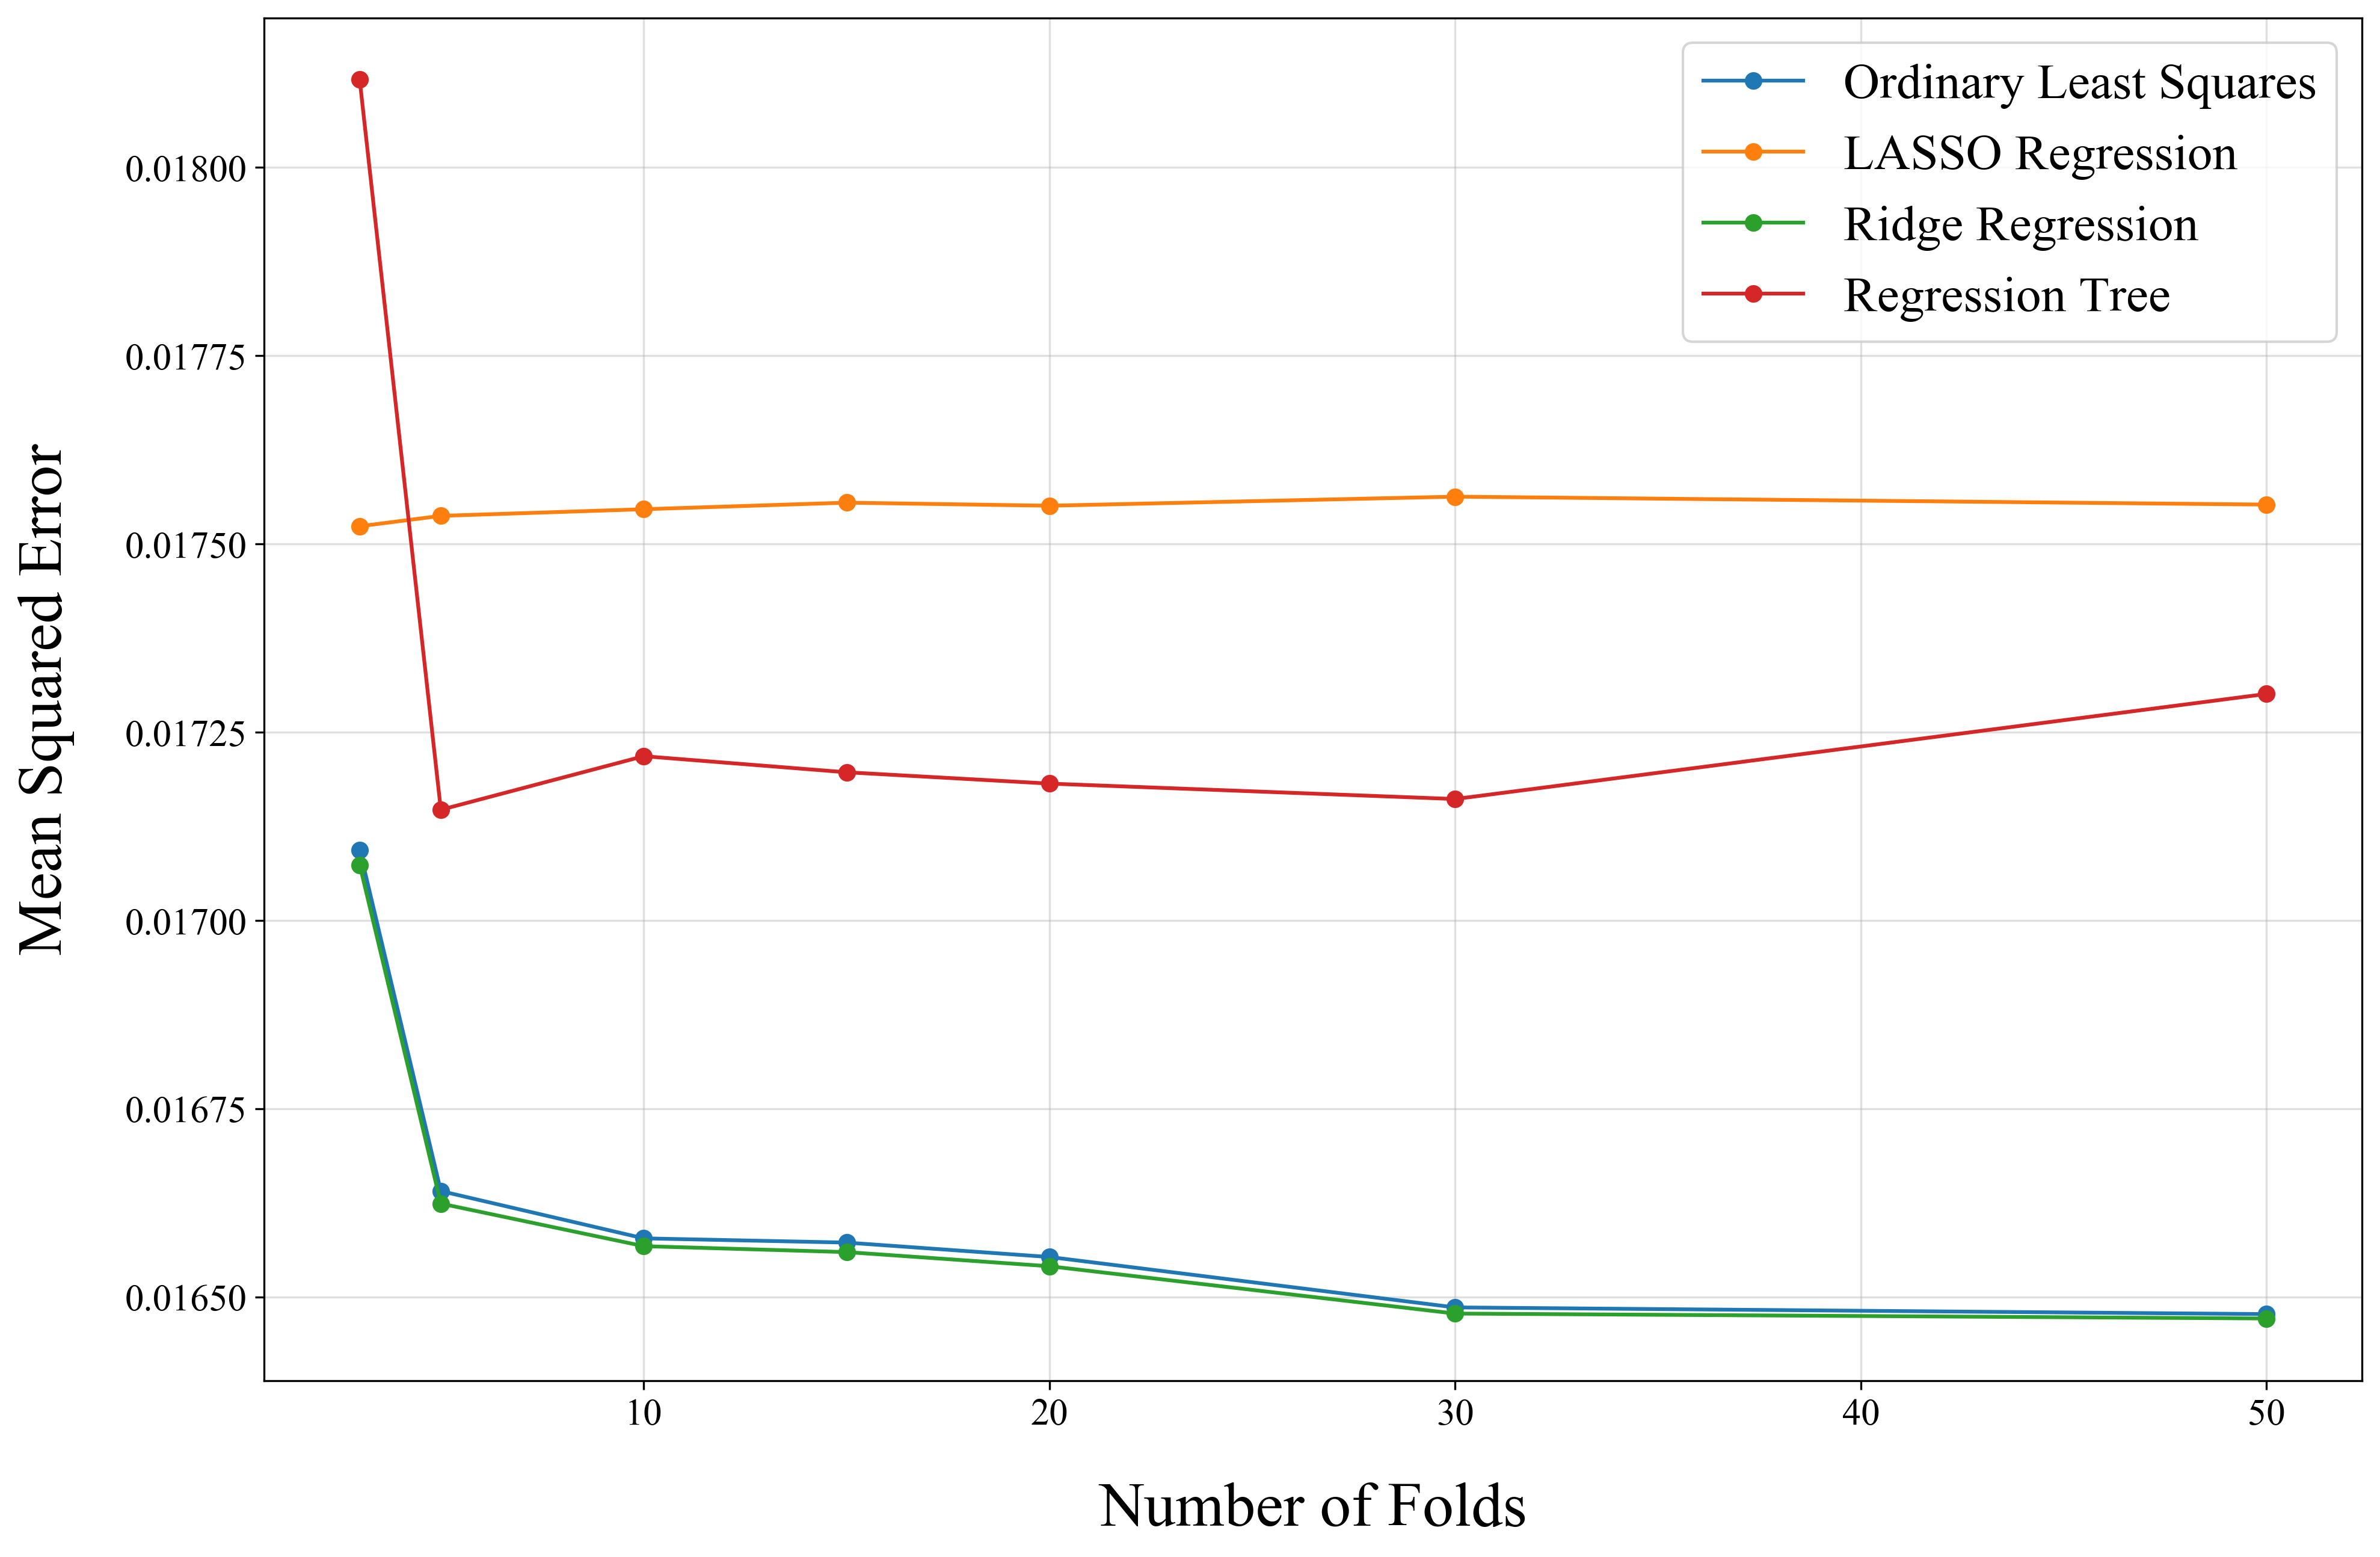

In [13]:
cv_testing_table = pd.DataFrame(index= [3, 5, 10, 15, 20, 30, 50], columns=models.keys())

s = 'FF5_'
cv_score_measure = 'neg_mean_squared_error'
for i in list(cv_testing_table.index):
    for m in list(models.keys()):

        s_ = s #+ '*'
        
        if cv_score_measure == 'neg_mean_squared_error':
            mult = -1
        else:
            mult = 1
            
        val = kfold_test_model(model=models[m], setup=s_, cv=i, scoring=cv_score_measure)
        cv_testing_table[m].loc[i] = val * mult # Because we are measuring negative mean squared error

cv_testing_table.columns = [estimator_names[i] for i in cv_testing_table.columns]

# Plot

fig, ax = plt.subplots(figsize=[15,10])
# ax.set_ylim(0.01625, 0.0195)
ax.plot(cv_testing_table, marker='o')
ax.legend(cv_testing_table.columns)
ax.set_xlabel('Number of Folds')
ax.set_ylabel('Mean Squared Error')

# Rolling Origin Evaluation Graphs

Text(0, 0.5, 'Mean Squared Error')

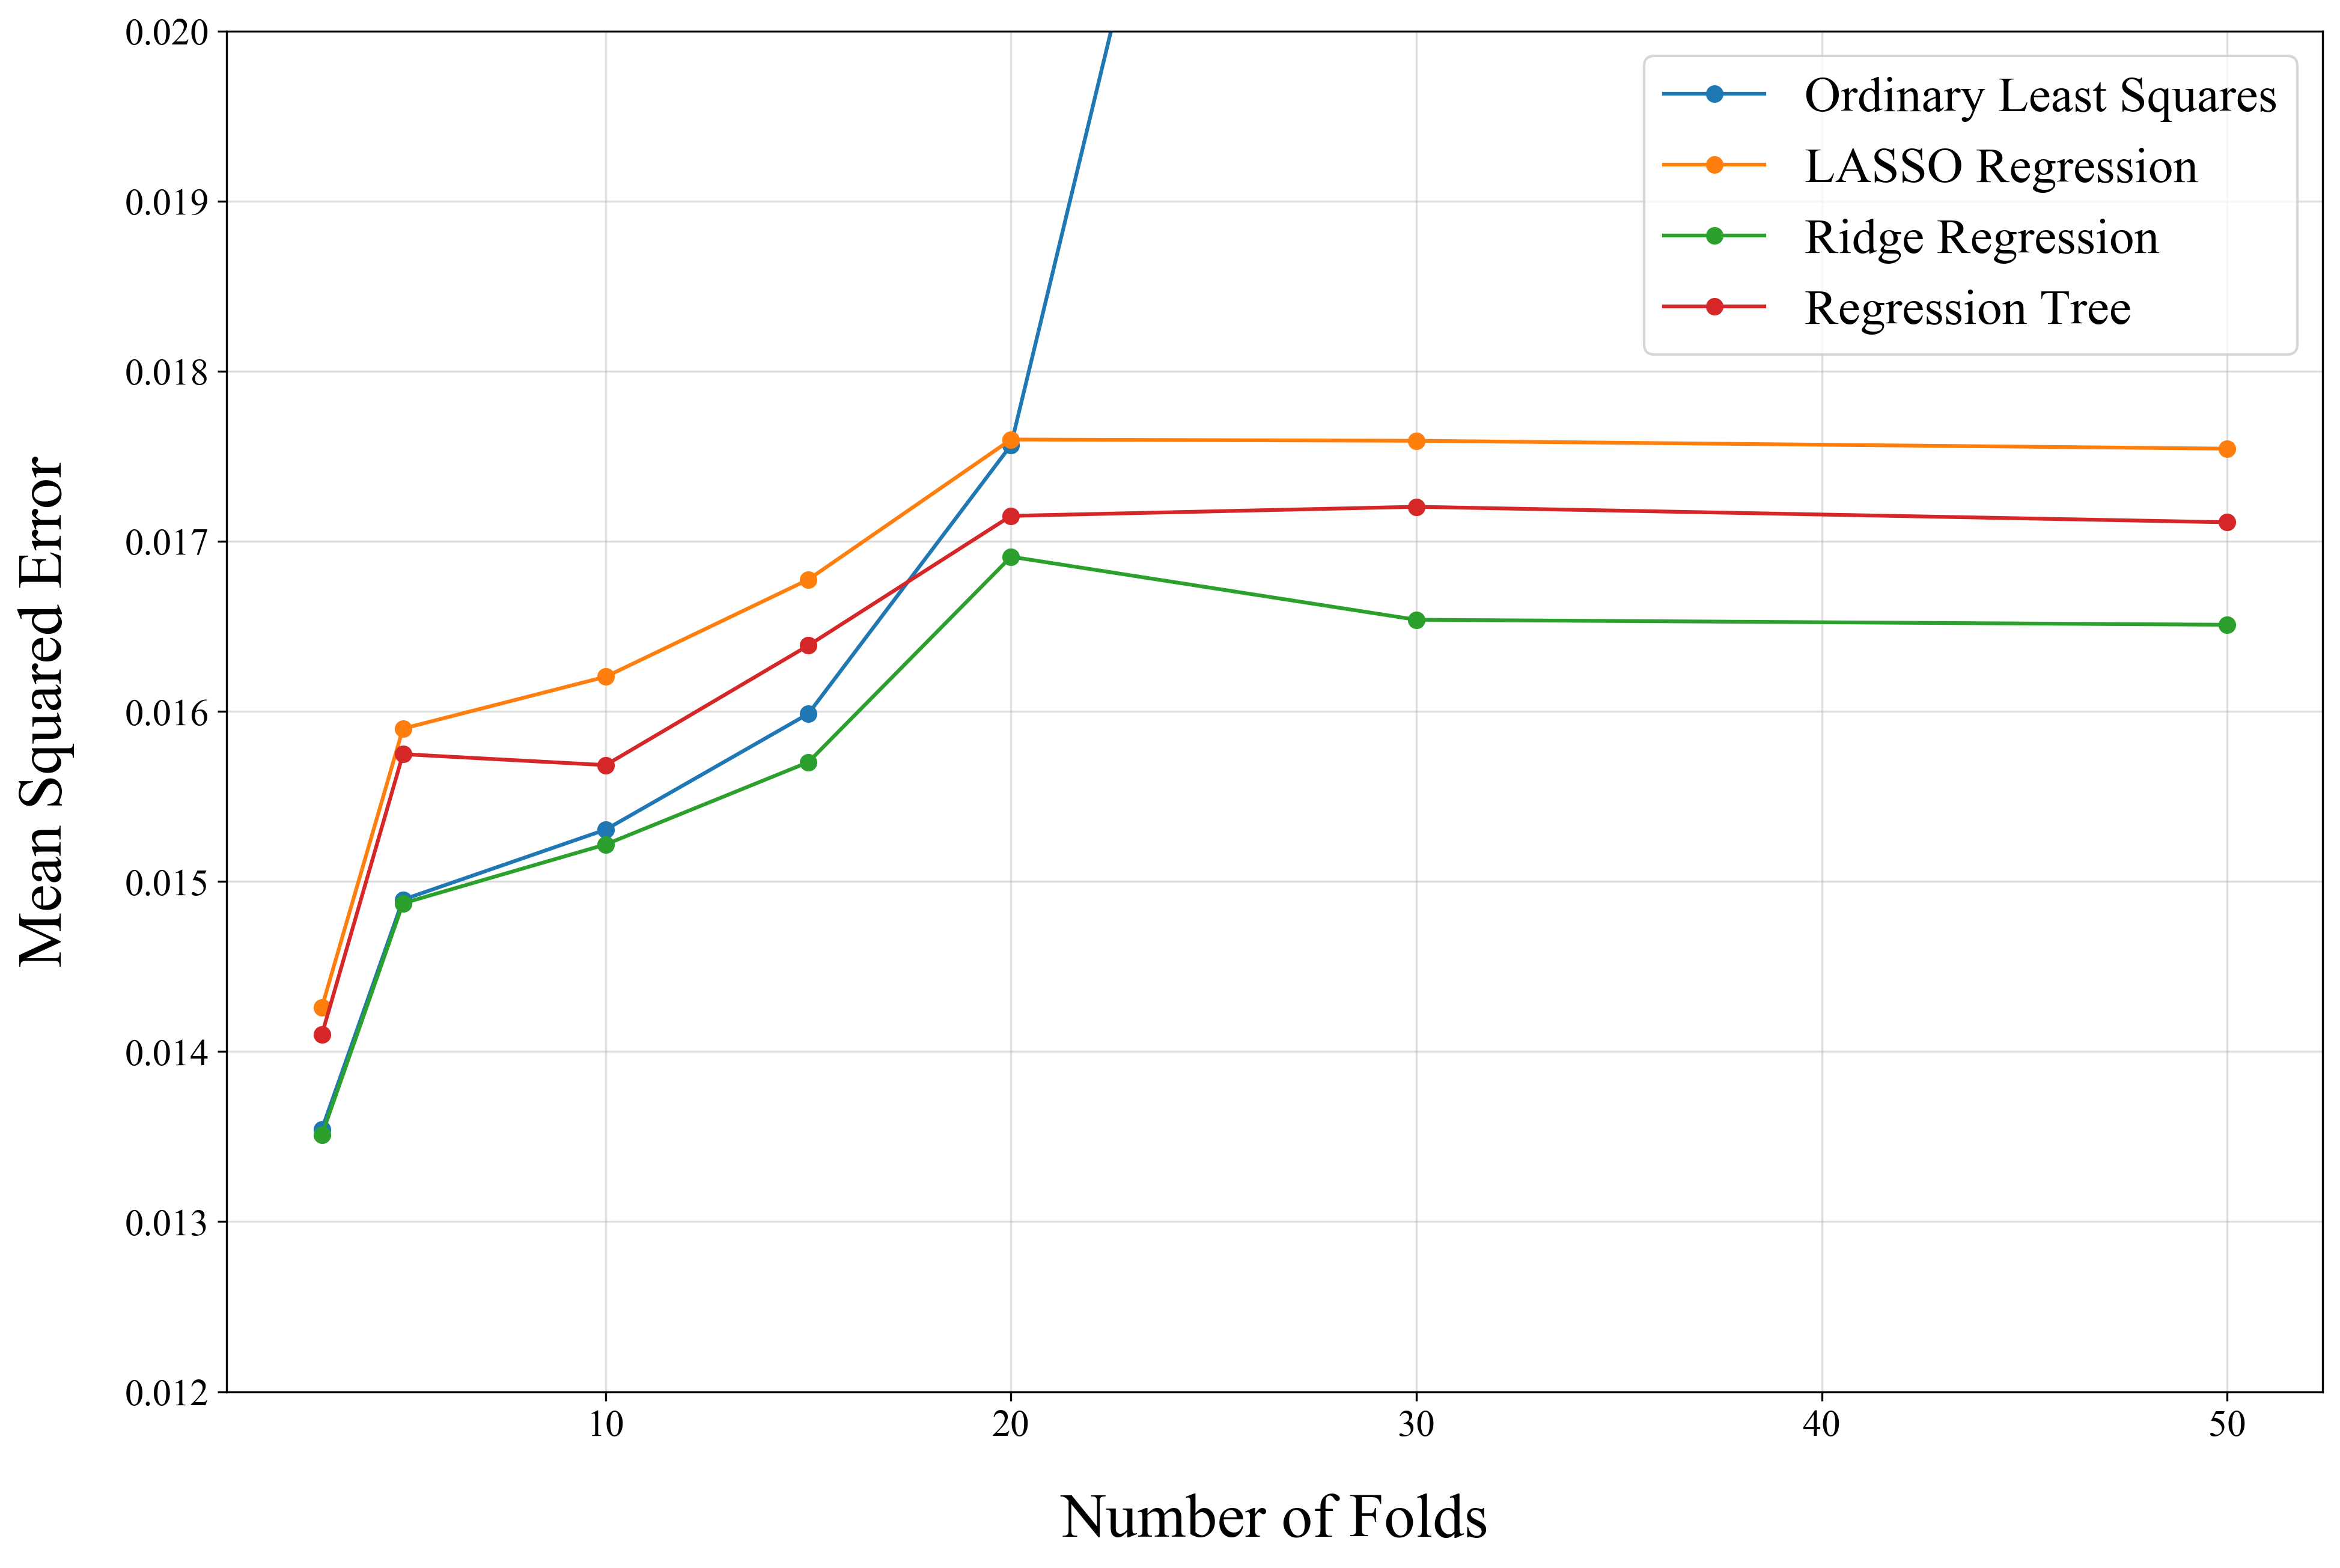

In [14]:
ro_testing_table = pd.DataFrame(index= [3, 5, 10, 15, 20, 30, 50], columns=models.keys())

s = 'FF5_'
for i in list(ro_testing_table.index):
    for m in list(models.keys()):

        s_ = s #+ '*'
            
        val = rolling_origin_validation(model=models[m], setup=s_, n_splits=i, scoring='mean_squared_error')
        ro_testing_table[m].loc[i] = val

ro_testing_table.columns = [estimator_names[i] for i in ro_testing_table.columns]

# Plot

fig, ax = plt.subplots(figsize=[15,10])
ax.set_ylim([0.012, 0.02])
ax.plot(ro_testing_table, marker='o')
ax.legend(ro_testing_table.columns)
ax.set_xlabel('Number of Folds')
ax.set_ylabel('Mean Squared Error')

# Hyperparameter Tuning Graphs

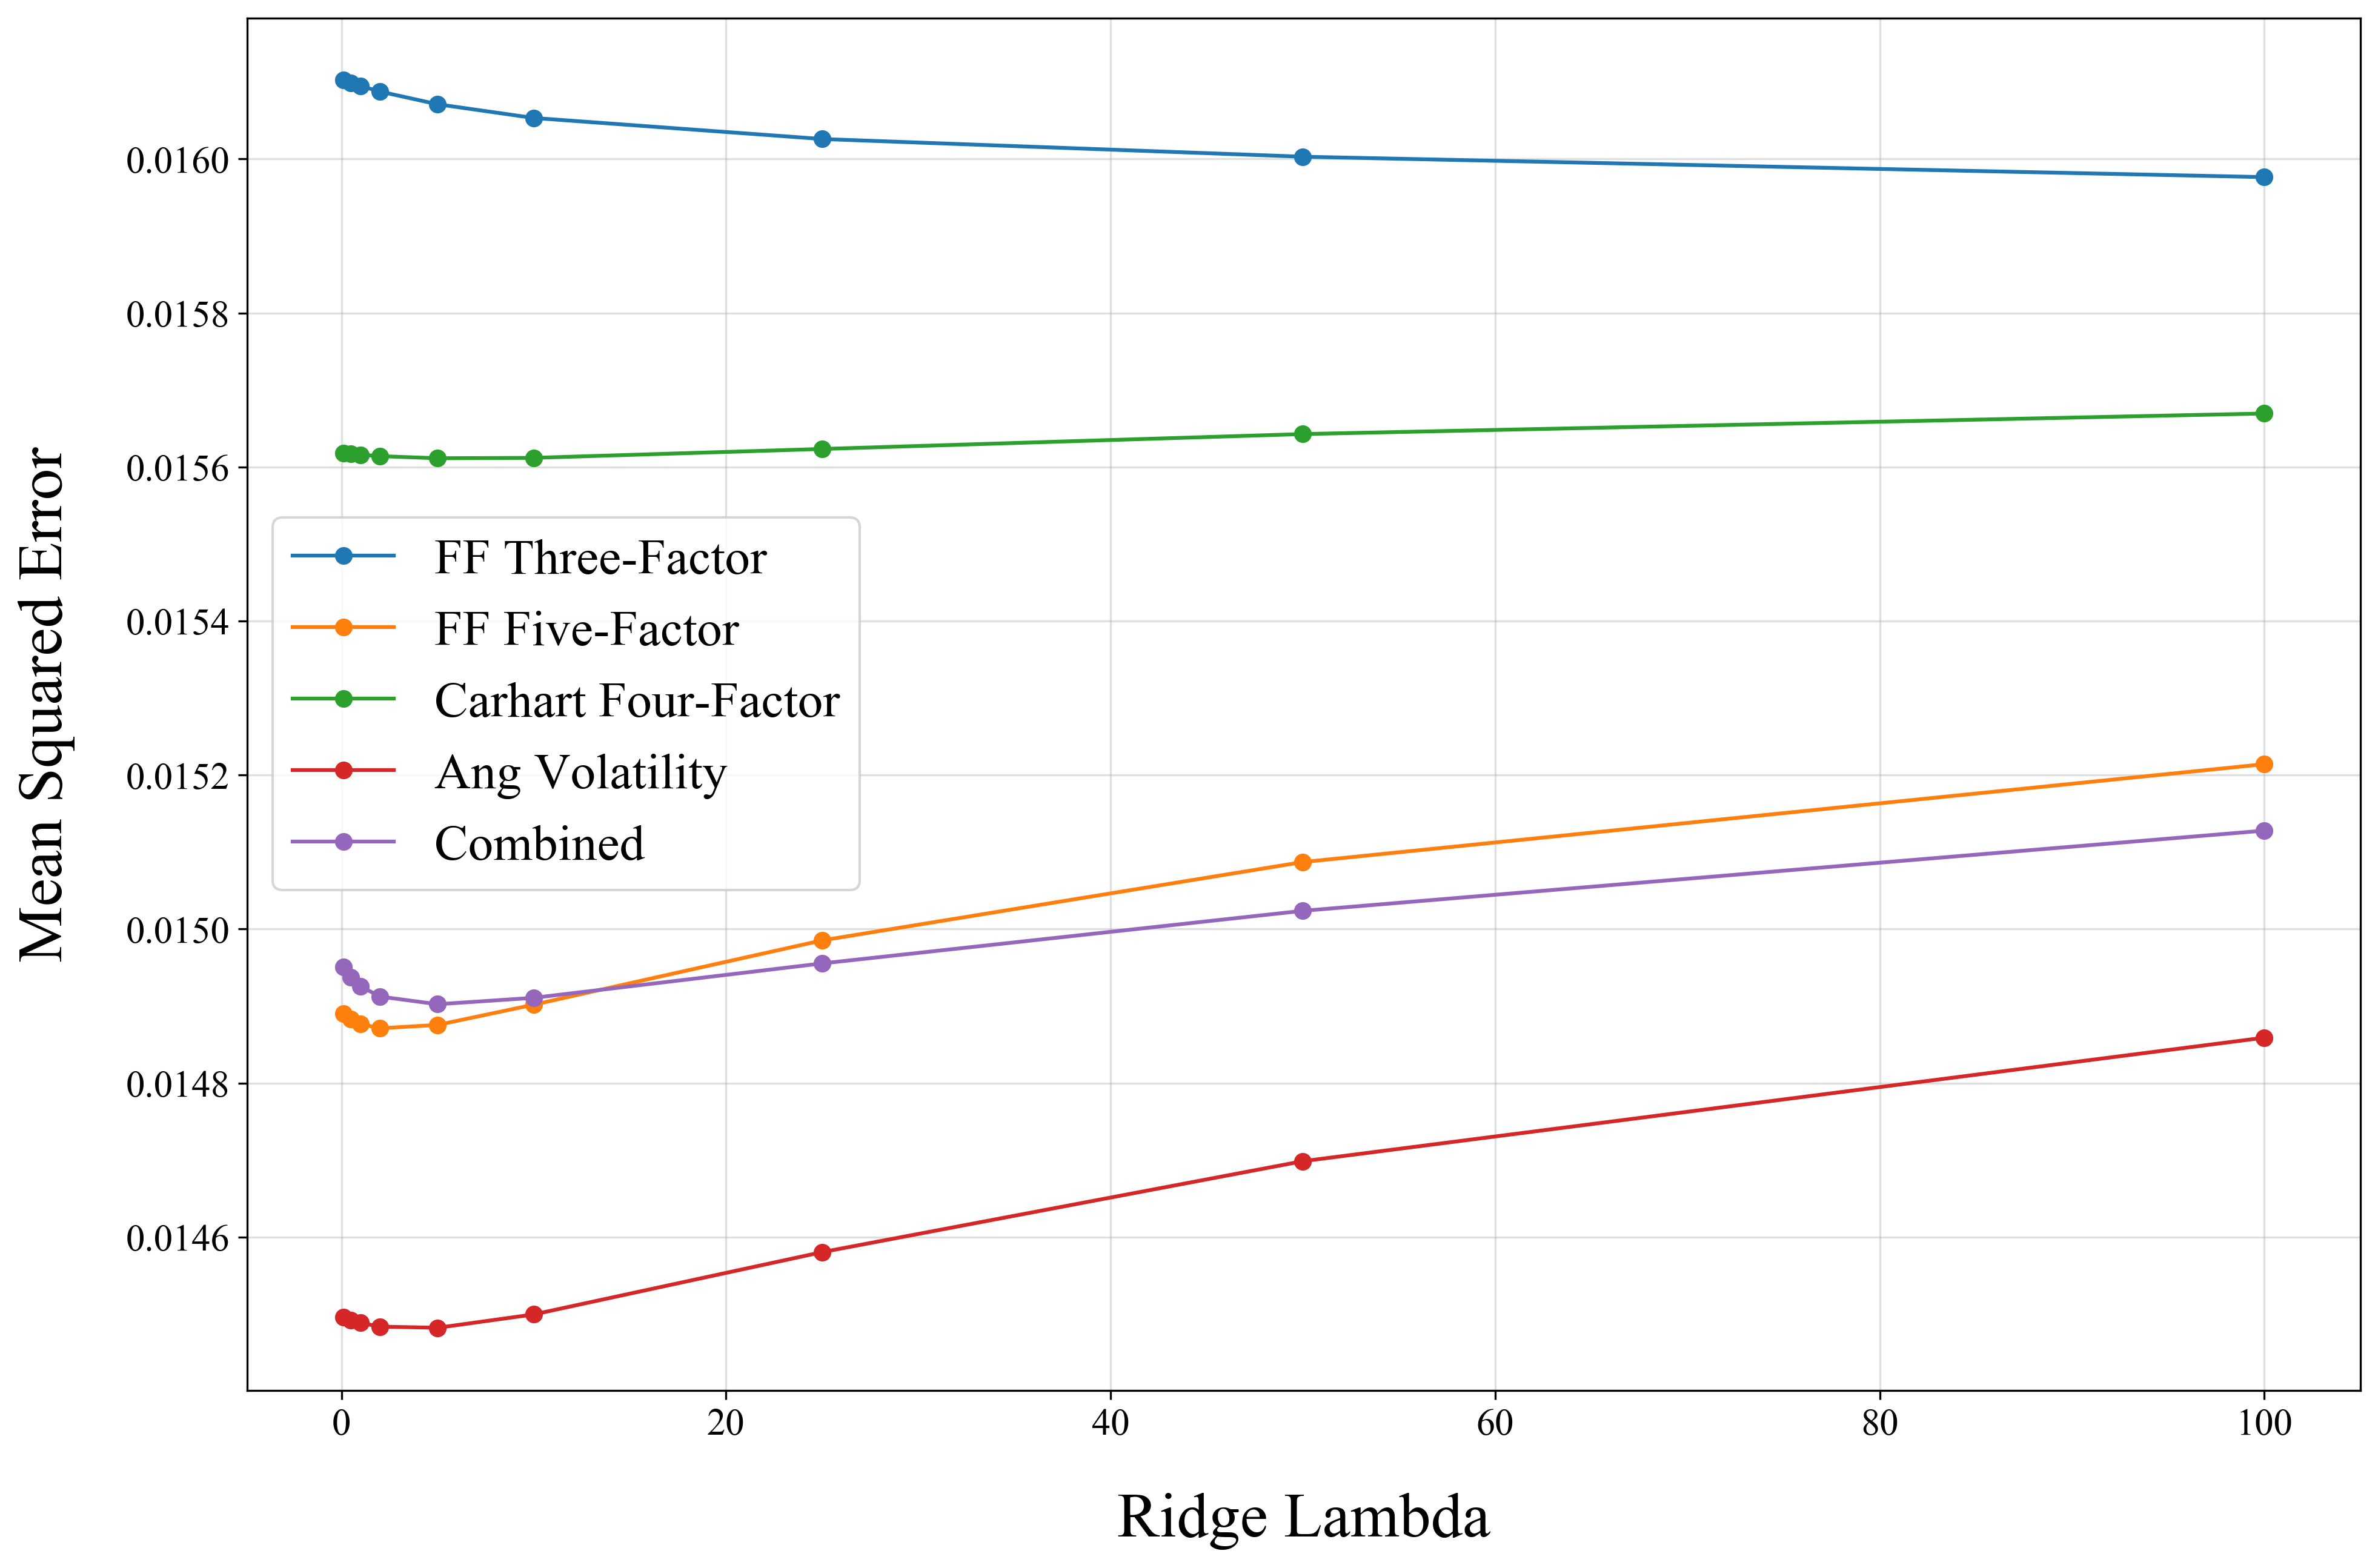

In [15]:
tuning_table = pd.DataFrame(index= [0.1, 0.5, 1, 2, 5, 10, 25, 50, 100], columns=setups_decomp)

for i in list(tuning_table.index):
    for s in setups_decomp:
        s_ = s
            
        val = rolling_origin_validation(model=Ridge(alpha=i), setup=s_, n_splits=cv, scoring='mean_squared_error')
        tuning_table[s].loc[i] = val

fig, ax = plt.subplots(figsize=[15,10])
# ax.set_ylim([0.014, 0.01625])
ax.plot(tuning_table, marker='o')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Ridge Lambda')
plt.legend([model_names[i[:-1]] for i in tuning_table.columns])

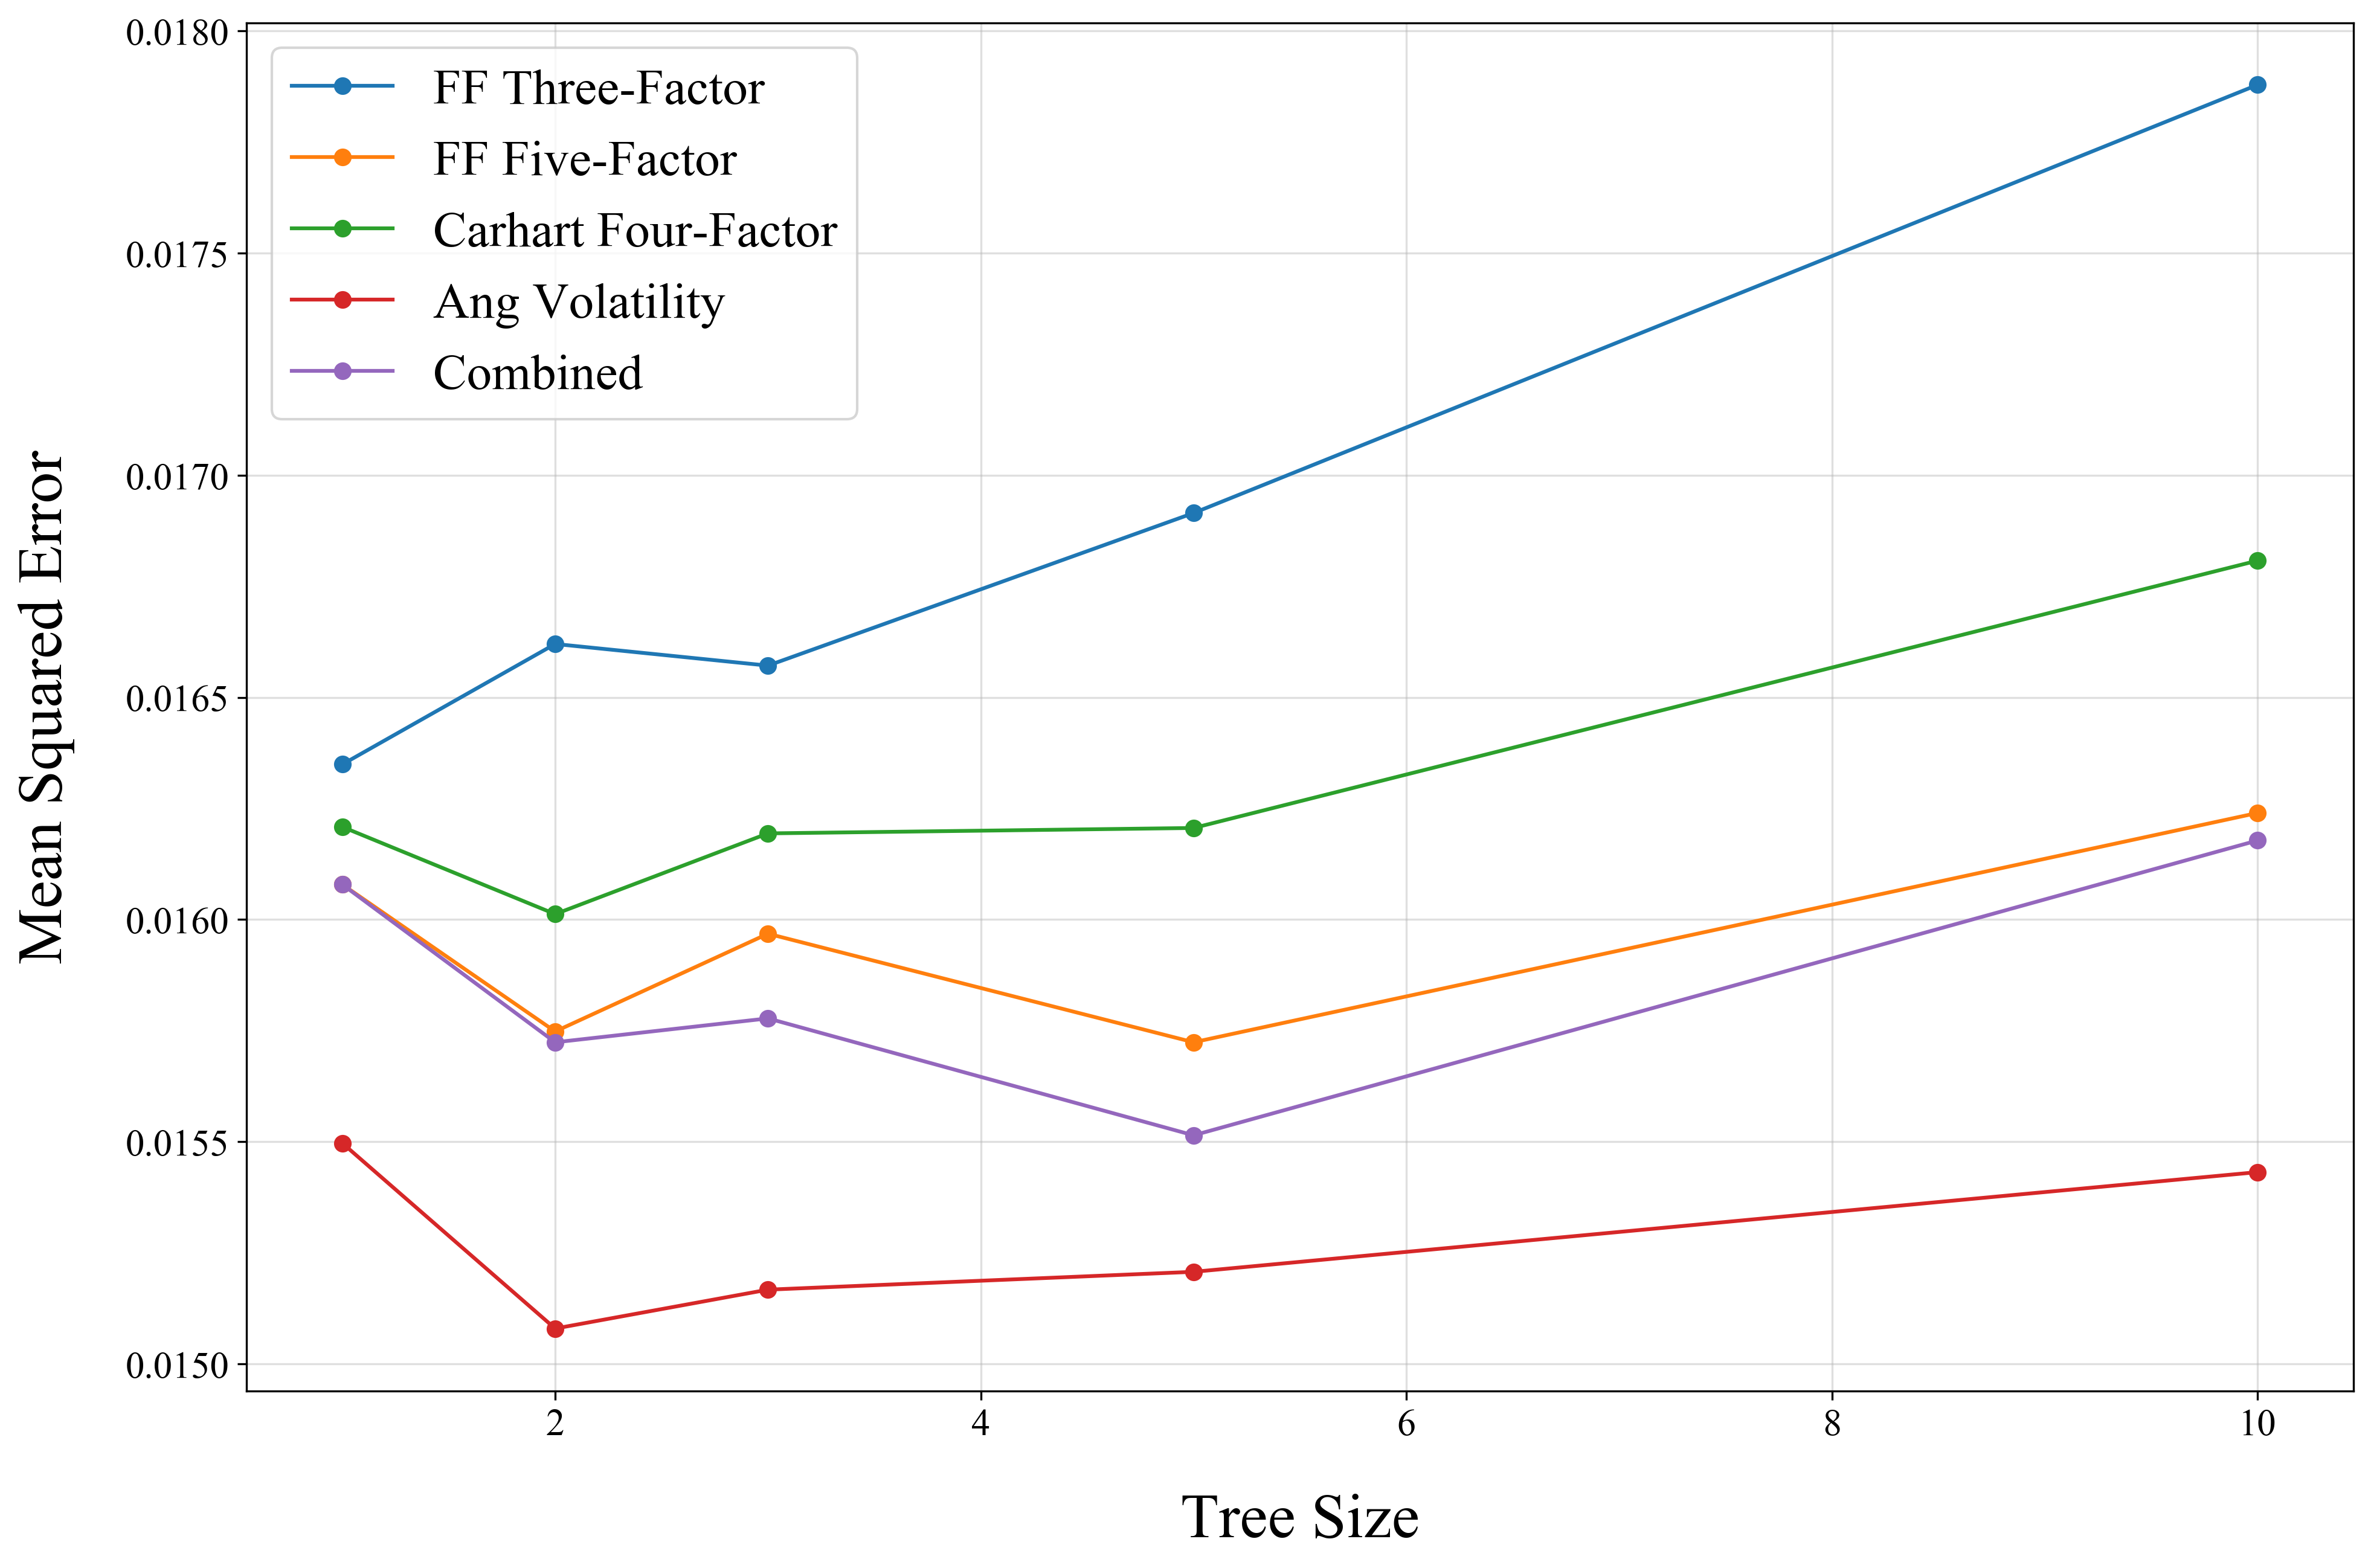

In [16]:
tuning_table = pd.DataFrame(index= [1, 2, 3, 5, 10], columns=setups_decomp)

for i in list(tuning_table.index):
    for s in setups_decomp:
        s_ = s
            
        val = rolling_origin_validation(model=DecisionTreeRegressor(max_depth=i), setup=s_, n_splits=cv, scoring='mean_squared_error')
        tuning_table[s].loc[i] = val

fig, ax = plt.subplots(figsize=[15,10])
# ax.set_ylim([0.014, 0.01625])
ax.plot(tuning_table, marker='o')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Tree Size')
plt.legend([model_names[i[:-1]] for i in tuning_table.columns])

# Coefficients

In [34]:
coef_setup = 'combined_'

### Average Model From Rolling Origin Evaluation

In [35]:
def ts_validated_reg_table(model, setup, n_splits):
        
    X_ = X[predictor_sets[setup]]
    y_ = y
    
    r2_vals = []
    cols = ['c'] + list(X_.columns)
    coefficients = pd.DataFrame(index=range(n_splits), columns=cols)
    pvals = pd.DataFrame(index=range(n_splits), columns=cols)
    
    splits = TimeSeriesSplit(n_splits=n_splits)
    index = 0
    
    for train_index, test_index in splits.split(X_):

        X_train = X_.loc[train_index]
        X_test = X_.loc[test_index]
        y_train = y_.loc[train_index]
        y_test = y_.loc[test_index]
        
        # Create model
        fitted_model = model.fit(X_train, y_train)
        
        # R-squared values
        pred = fitted_model.predict(X_test)
        r2_val = r2_score(y_test, pred)
        r2_vals.append(r2_val)
        
        # Append coefficients
        
        coefficients.loc[index] = np.array([fitted_model.intercept_] + list(fitted_model.coef_))
        pvals.loc[index] = stats.coef_pval(model, X_train, y_train)
        
        index += 1
    
    average_model = pd.DataFrame({'Coefficient':coefficients.mean(), 'P-Value':pvals.mean()})
    average_model = round(average_model, 3)
    
    return average_model

ols_coefficient_table = ts_validated_reg_table(LinearRegression(), coef_setup, cv)
lasso_coefficient_table = ts_validated_reg_table(Lasso(alpha=2), coef_setup, cv)
ridge_coefficient_table = ts_validated_reg_table(Ridge(alpha=2), coef_setup, cv)

In [36]:
table = pd.DataFrame(index=setups_decomp, columns=['Linear', 'Polynomial'])
for s in setups_decomp:
    for spec in ['', '*']:
        if spec == '':
            poly = 'Linear'
        else:
            poly = 'Polynomial'
        val = ts_validated_reg_table(LinearRegression(), s+spec, cv).loc['c']['P-Value']
        table.loc[s][poly] = round(val, 3)

table.index = [i[:-1] for i in table.index]
table

,Linear,Polynomial
FF3,0.122,0
FF5,0,0
mom,0,0
vol,0.092,0
combined,0.108,0.142


In [37]:

print(ts_validated_reg_table(LinearRegression(), 'FF3_', cv))
print(ts_validated_reg_table(LinearRegression(), 'FF5_', cv))
print(ts_validated_reg_table(LinearRegression(), 'mom_', cv))
print(ts_validated_reg_table(LinearRegression(), 'vol_', cv))
print(ts_validated_reg_table(LinearRegression(), 'combined_', cv))

     Coefficient  P-Value
c          0.007    0.122
MKT        0.240    0.000
SMB        0.230    0.000
HML       -0.146    0.000
     Coefficient  P-Value
c          0.021    0.000
MKT        0.285    0.000
SMB       -0.484    0.000
HML        0.324    0.000
RMW       -0.889    0.000
CMA       -0.077    0.022
     Coefficient  P-Value
c          0.022      0.0
MKT        0.192      0.0
SMB        0.150      0.0
HML       -0.521      0.0
UMD       -0.402      0.0
     Coefficient  P-Value
c         -0.001    0.092
MKT        0.265    0.000
SMB       -0.458    0.000
HML        0.457    0.000
VOL       -0.712    0.000
     Coefficient  P-Value
c          0.003    0.108
MKT        0.262    0.000
SMB       -0.453    0.000
HML        0.336    0.000
RMW       -0.240    0.110
CMA        0.175    0.176
UMD       -0.109    0.000
VOL       -0.595    0.000


In [38]:
%run config.ipynb

ts_validated_reg_table(LinearRegression(), 'combined_', cv)


,Coefficient,P-Value
c,0.003,0.108
MKT,0.262,0.000
SMB,-0.453,0.000
HML,0.336,0.000
RMW,-0.240,0.110
CMA,0.175,0.176
UMD,-0.109,0.000
VOL,-0.595,0.000


In [39]:
%run config.ipynb

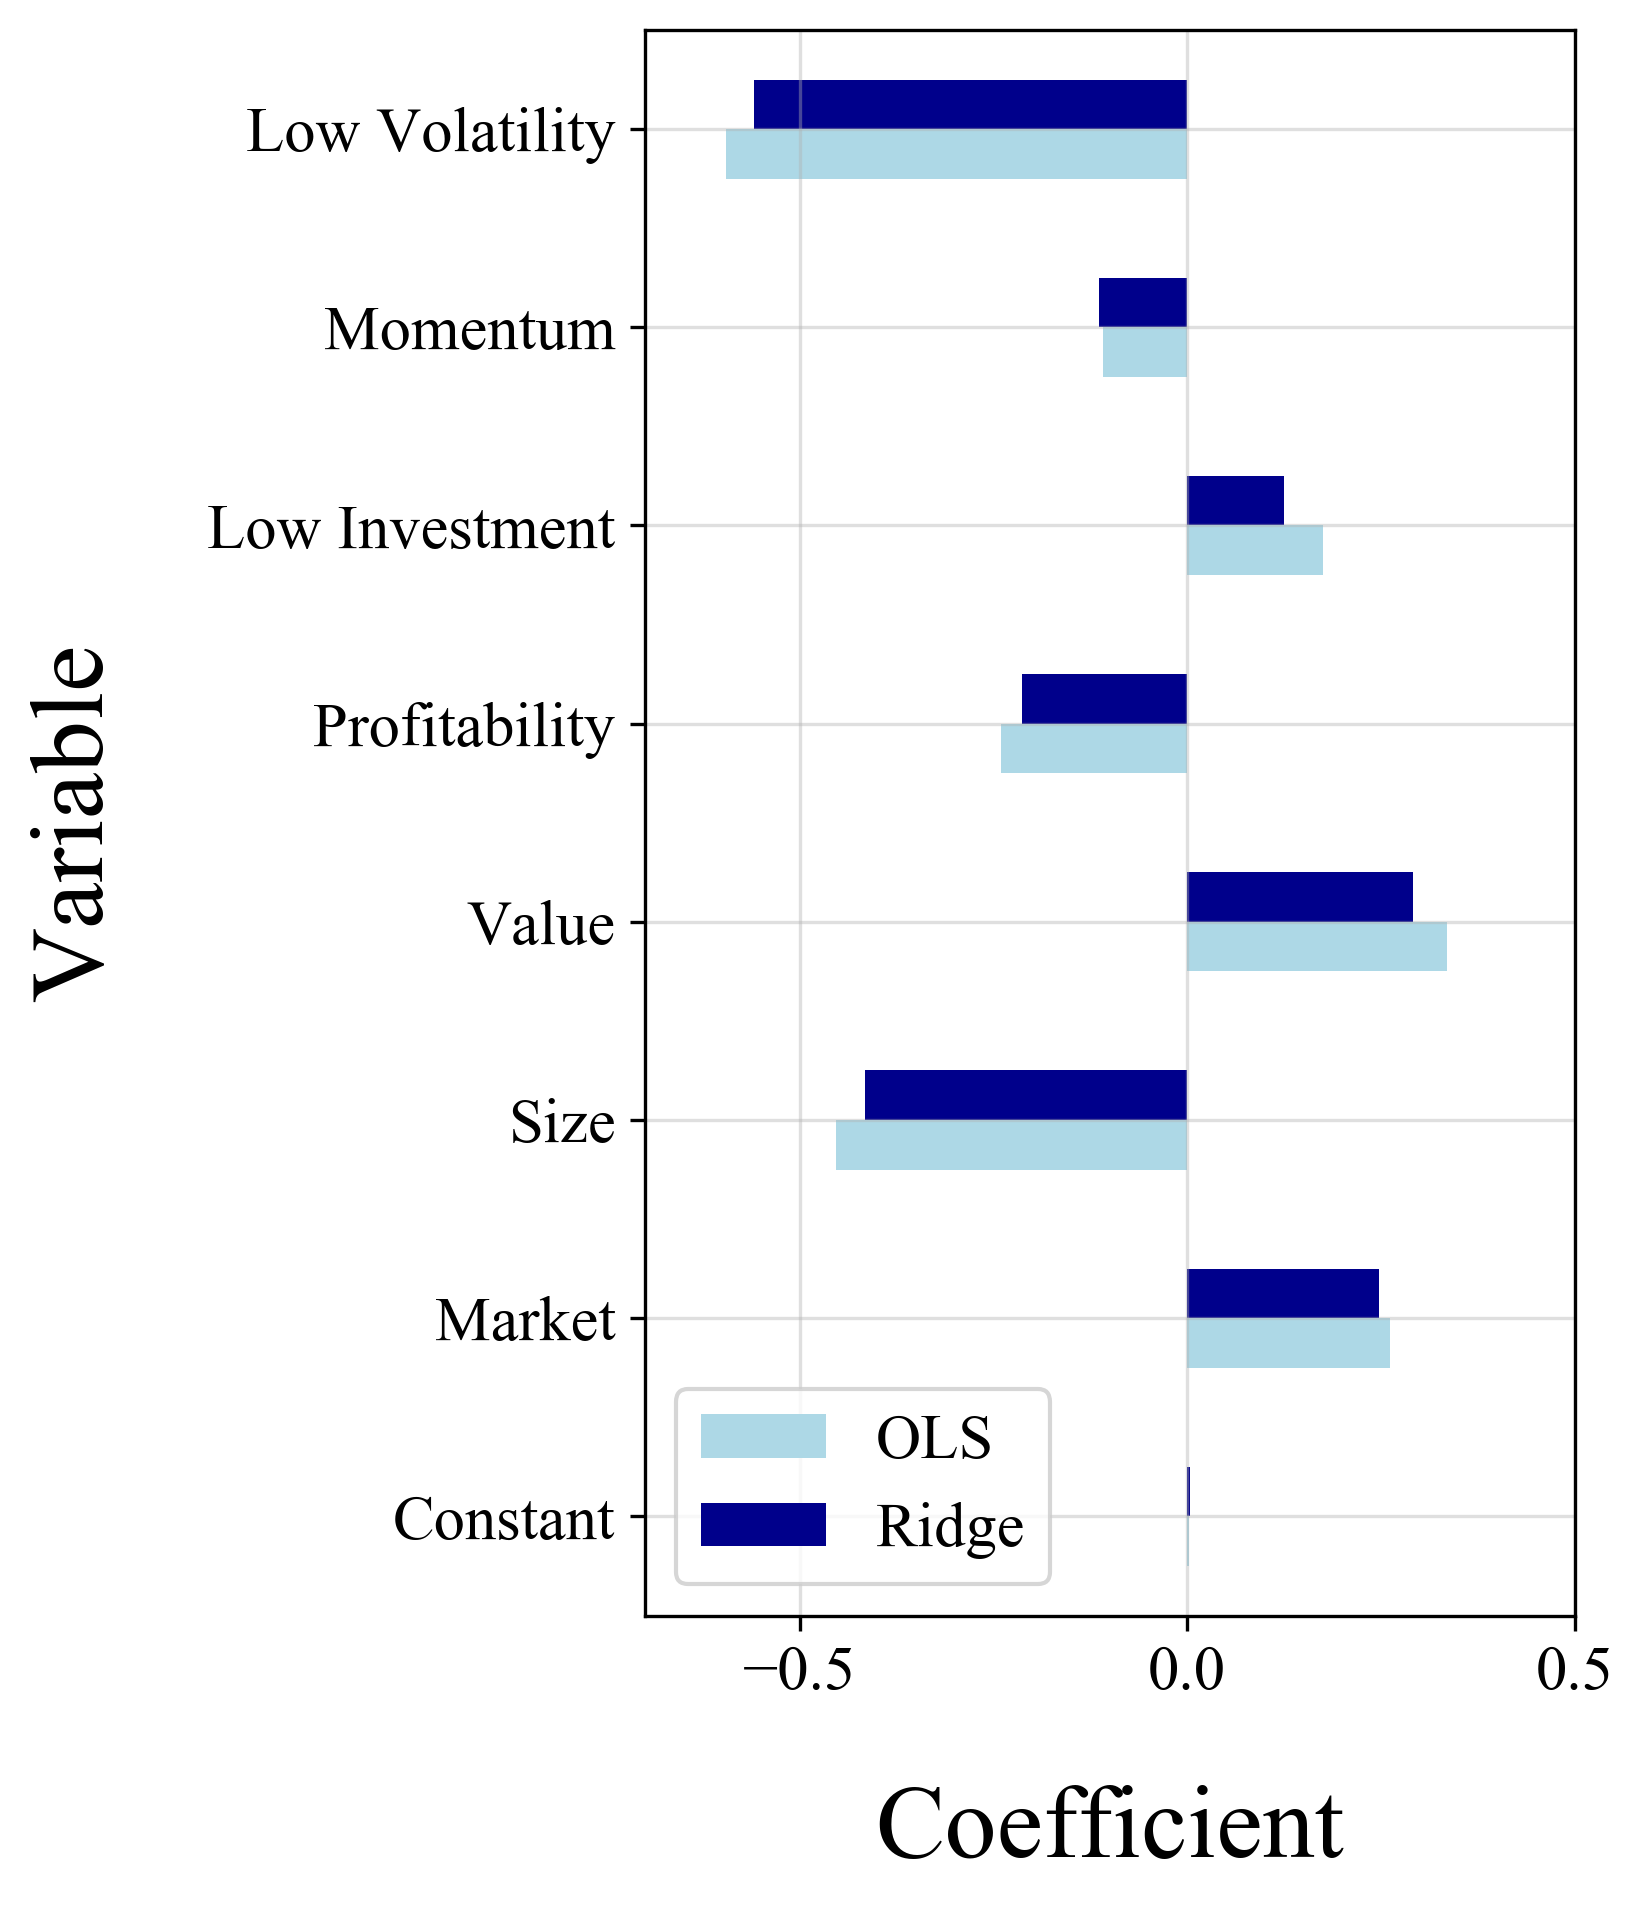

In [47]:

coef_comp = pd.concat([ols_coefficient_table['Coefficient'], ridge_coefficient_table['Coefficient']], axis=1)

coef_comp.columns = ['OLS', 'Ridge']

coef_comp.index = [factor_names[i] for i in coef_comp.index]

coef_comp.plot(kind='barh', color=['lightblue', 'darkblue'], figsize=[4,7])

plt.xlim([-0.7, 0.5])
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.legend(loc=3, fontsize=15)




[Text(2131.25, 3963.75, 'VOL <= -0.02\nmse = 0.018\nsamples = 136593\nvalue = 0.006'),
 Text(1162.5, 2831.25, 'HML <= 0.269\nmse = 0.023\nsamples = 48420\nvalue = 0.042'),
 Text(775.0, 1698.75, 'UMD <= -0.098\nmse = 0.021\nsamples = 47891\nvalue = 0.04'),
 Text(387.5, 566.25, 'mse = 0.032\nsamples = 3821\nvalue = 0.093'),
 Text(1162.5, 566.25, 'mse = 0.02\nsamples = 44070\nvalue = 0.035'),
 Text(1550.0, 1698.75, 'mse = 0.154\nsamples = 529\nvalue = 0.266'),
 Text(3100.0, 2831.25, 'UMD <= 0.119\nmse = 0.013\nsamples = 88173\nvalue = -0.014'),
 Text(2325.0, 1698.75, 'VOL <= 0.055\nmse = 0.012\nsamples = 84273\nvalue = -0.01'),
 Text(1937.5, 566.25, 'mse = 0.011\nsamples = 70056\nvalue = -0.003'),
 Text(2712.5, 566.25, 'mse = 0.017\nsamples = 14217\nvalue = -0.041'),
 Text(3875.0, 1698.75, 'SMB <= -0.028\nmse = 0.023\nsamples = 3900\nvalue = -0.115'),
 Text(3487.5, 566.25, 'mse = 0.024\nsamples = 1261\nvalue = -0.19'),
 Text(4262.5, 566.25, 'mse = 0.018\nsamples = 2639\nvalue = -0.079')]

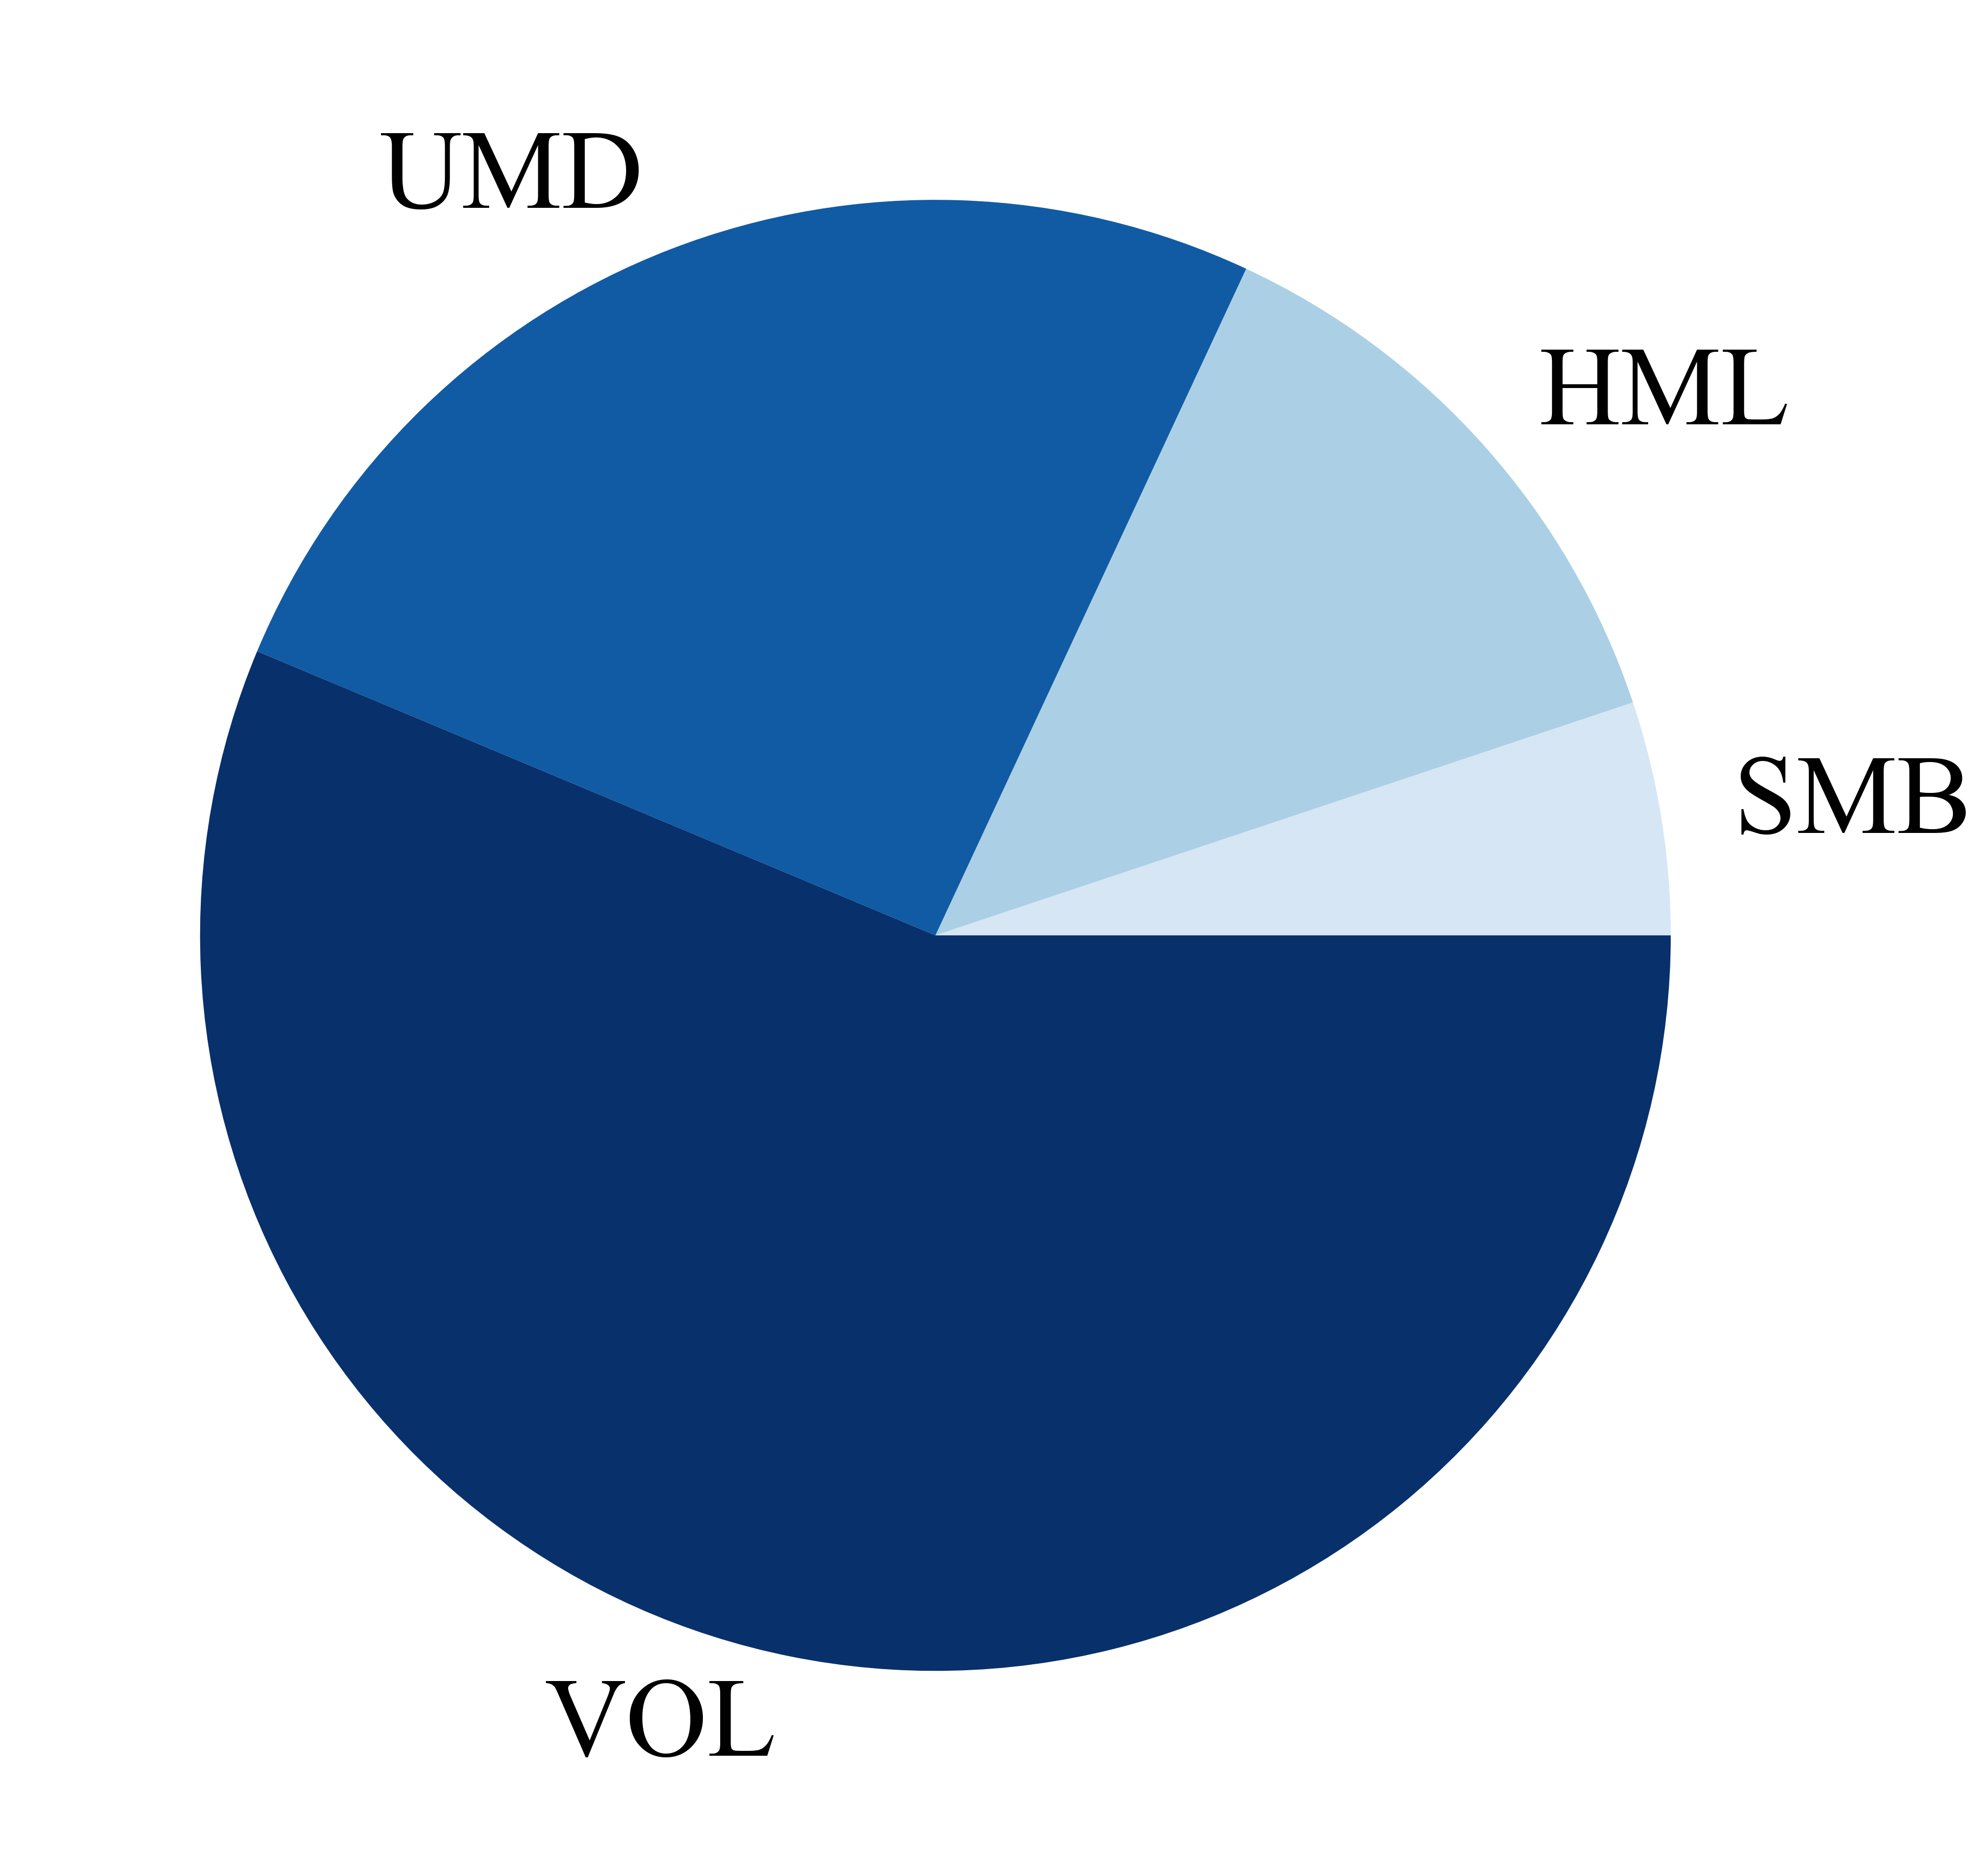

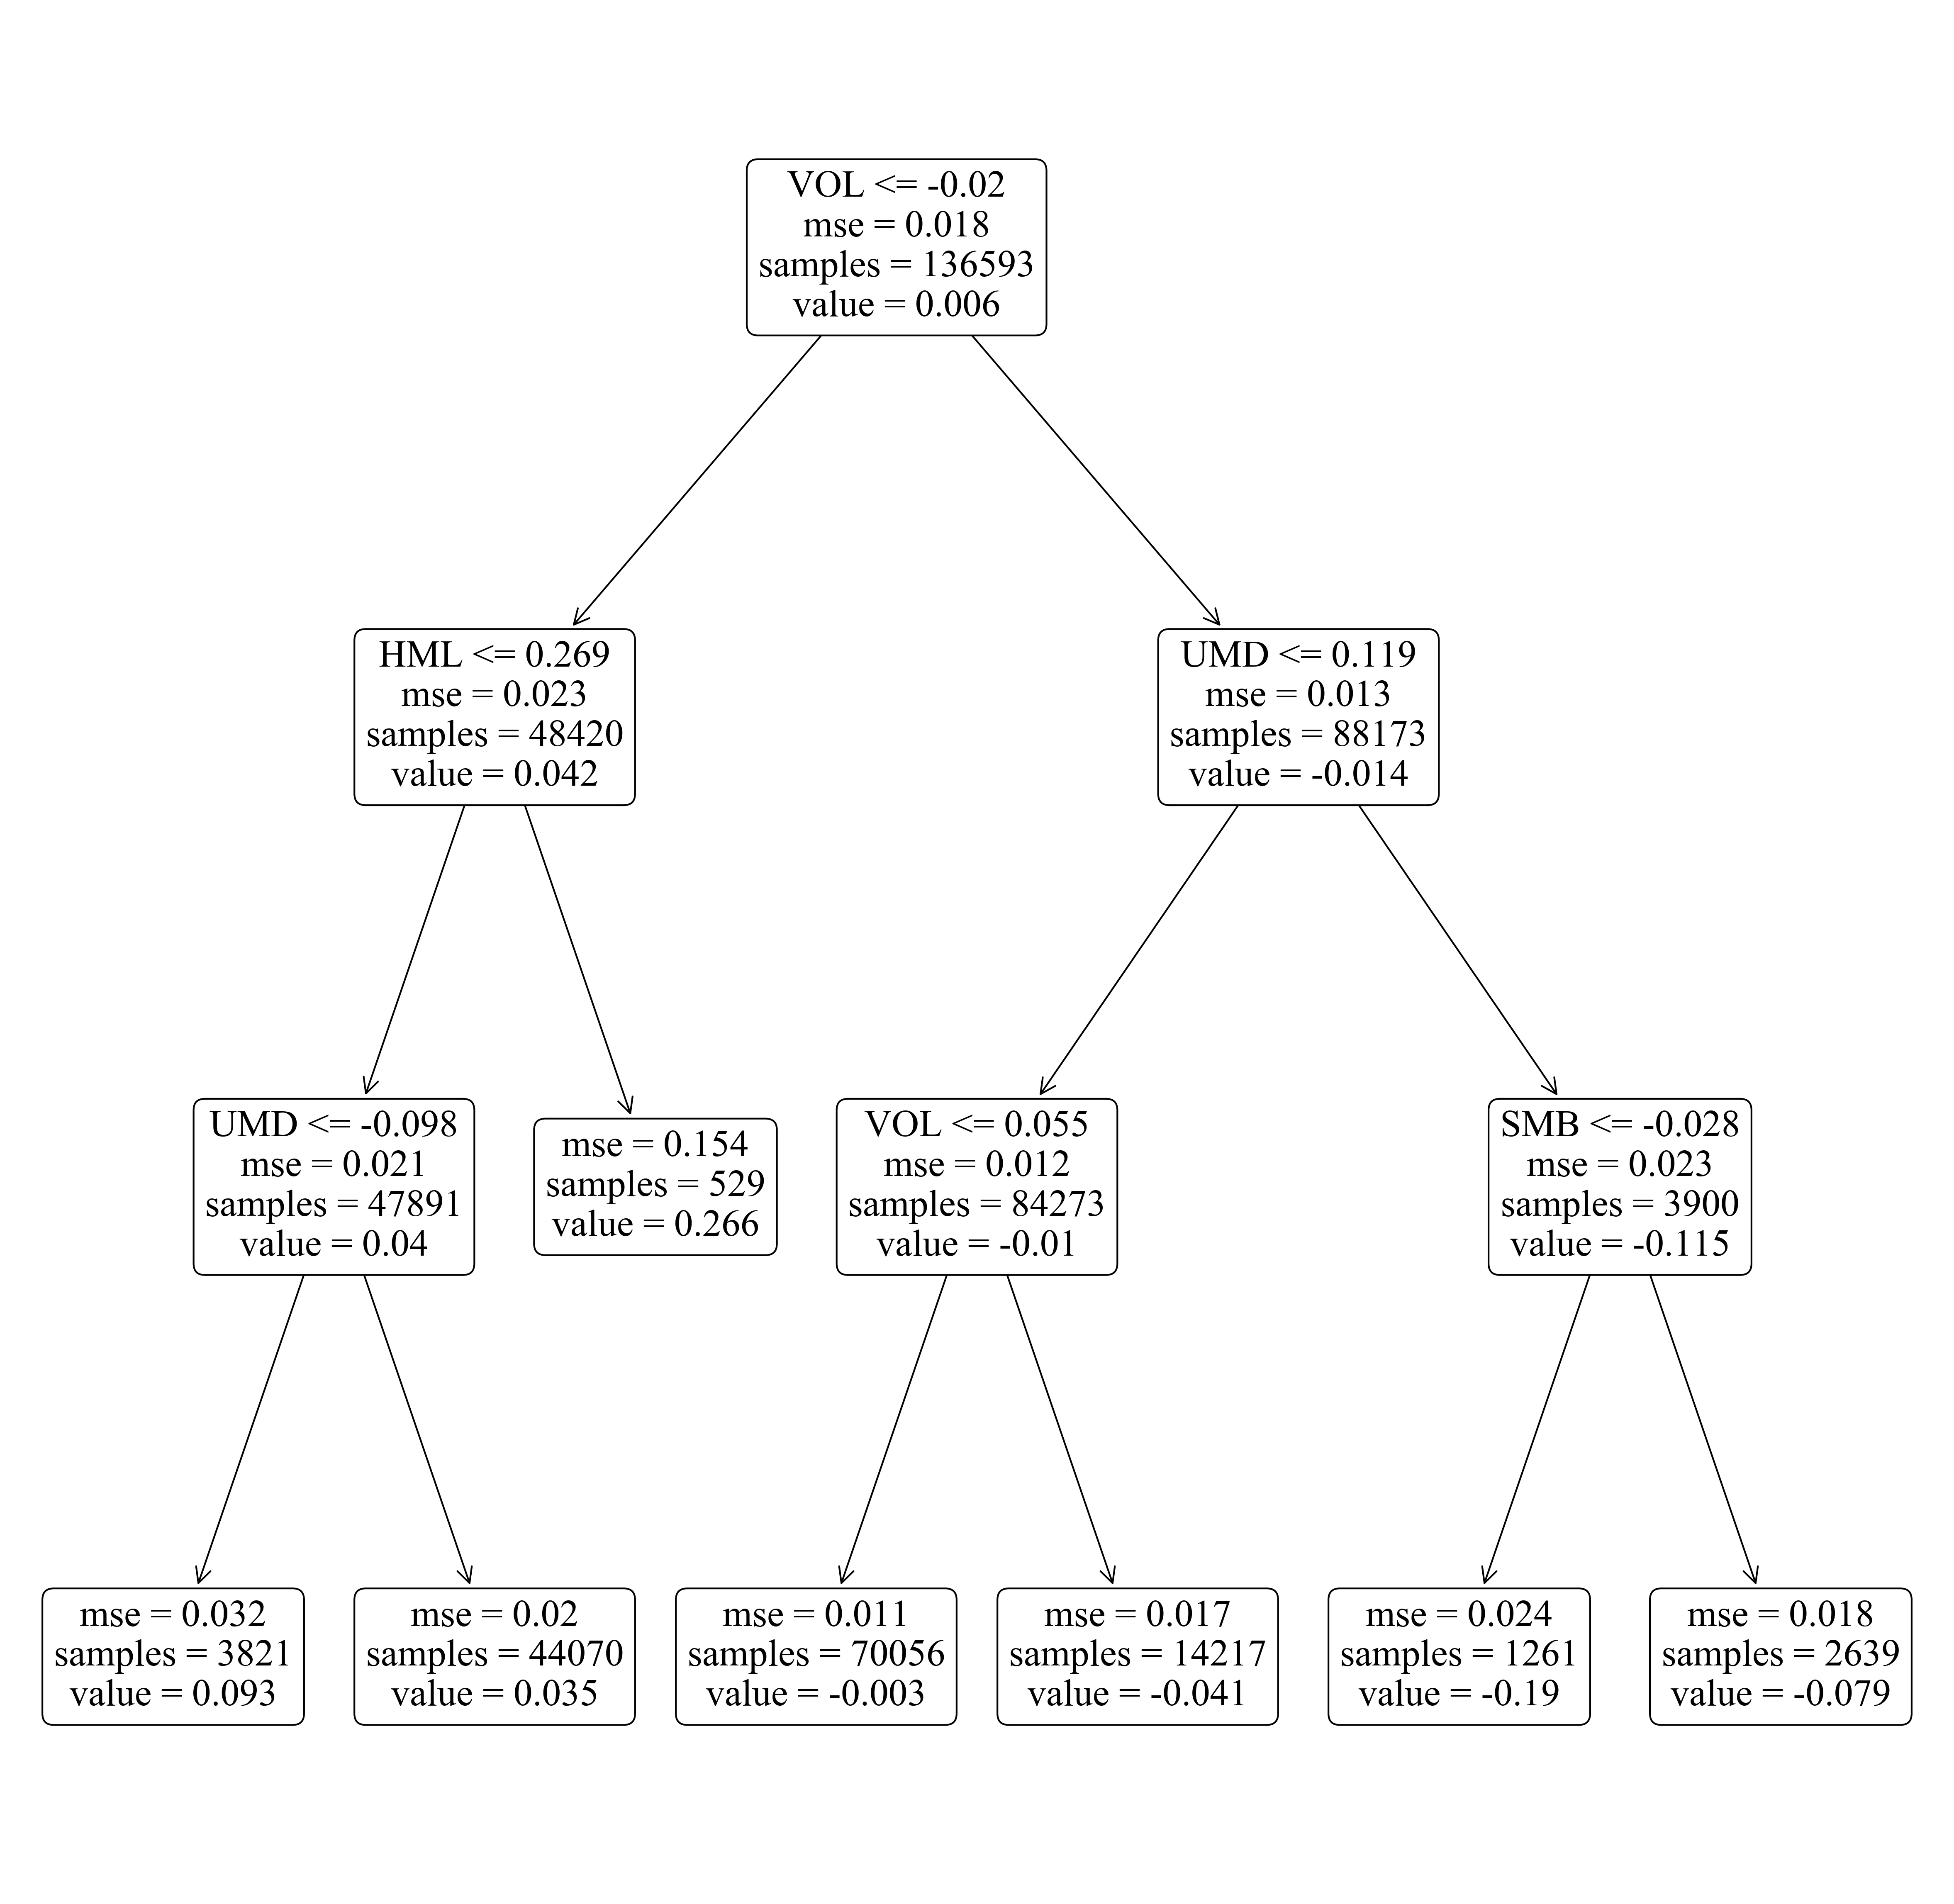

In [48]:

tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X[predictor_sets[coef_setup]], y)
tree_coef = pd.DataFrame(index=predictor_sets[coef_setup], data={'Coefficient':tree_model.feature_importances_})

# tree_coef.index = [factor_names[i] for i in tree_coef.index]

tree_coef.plot(kind='pie', legend=False, figsize=[15,15], subplots=True, cmap='Blues', textprops={'fontsize':50})


plt.ylabel('')



plt.figure(figsize=[20,20], dpi=300)
# tree.plot_tree(tree_model, rounded=True, feature_names=[factor_names[i] for i in predictor_sets[coef_setup]], fontsize=22)
tree.plot_tree(tree_model, rounded=True, feature_names=predictor_sets[coef_setup],fontsize=22)


# Standardized Variable Importance Table

In [65]:
ols_importances = abs(ols_coefficient_table['Coefficient'])
lasso_importances = abs(lasso_coefficient_table['Coefficient'])
ridge_importances = abs(ridge_coefficient_table['Coefficient'])
tree_importances = tree_coef.copy()

importances = [ols_importances, lasso_importances, ridge_importances, tree_importances]
importances_names = ['OLS', 'LASSO', 'Tree', 'Ridge']

In [66]:
importance_table = pd.concat([pd.DataFrame(i) for i in importances], axis=1)
importance_table.columns = importances_names
importance_table = importance_table.reindex(['c'] + list(importance_table.index[:-1]))
importance_table.fillna(value=0, inplace=True)
importance_table.index = [factor_names[i] for i in importance_table.index]
importance_table

,OLS,LASSO,Tree,Ridge
Constant,0.003,0.007,0.004,0.000000
Low Investment,0.175,0.000,0.125,0.000000
Value,0.336,0.000,0.291,0.129276
Market,0.262,0.000,0.248,0.000000
Profitability,0.240,0.000,0.213,0.000000
Size,0.453,0.000,0.416,0.051285
Momentum,0.109,0.000,0.114,0.256324
Low Volatility,0.595,0.000,0.559,0.563116


In [67]:
def loc(i):
    return [(1 if 2%i > 0 else 0), (1 if i%2 > 0 else 0)]

In [68]:
%run config.ipynb

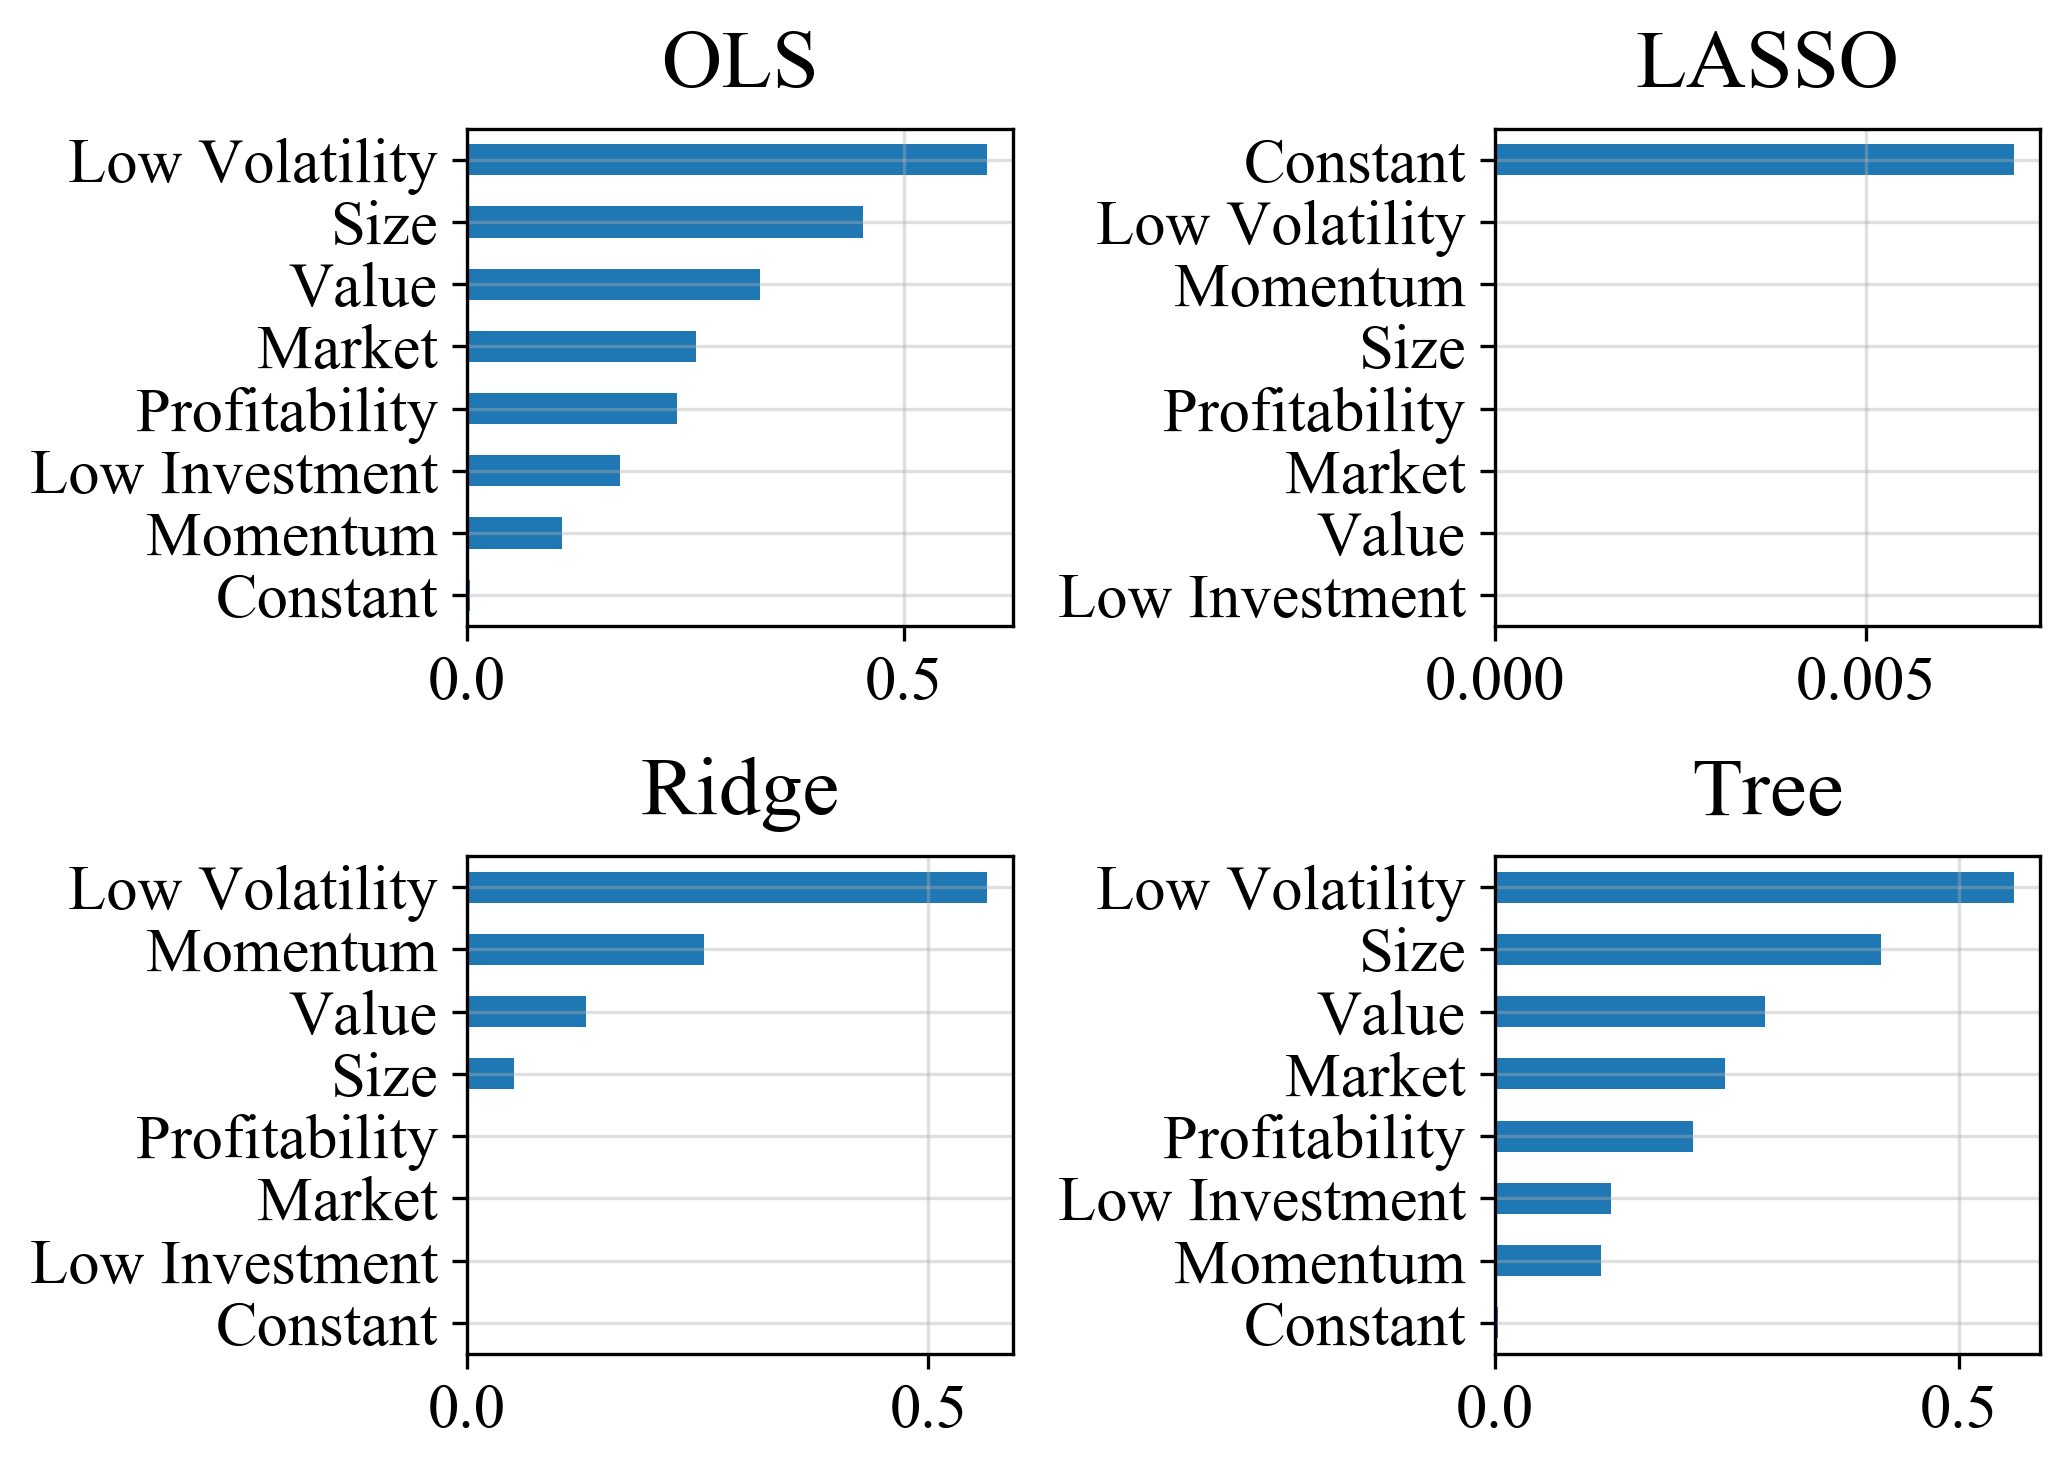

In [69]:
fig, ax = plt.subplots(2,2, figsize=[7,5])


# OLS
plot_data = importance_table['OLS'].sort_values()
ax[0,0].set_title('OLS', fontsize=20, pad=10)
plot_data.plot(kind='barh', ax=ax[0,0])

# LASSO
plot_data = importance_table['LASSO'].sort_values()
ax[0,1].set_title('LASSO', fontsize=20, pad=10)
plot_data.plot(kind='barh', ax=ax[0,1])

# Ridge
plot_data = importance_table['Ridge'].sort_values()
ax[1,0].set_title('Ridge', fontsize=20, pad=10)
plot_data.plot(kind='barh', ax=ax[1,0])

# Tree
plot_data = importance_table['Tree'].sort_values()
ax[1,1].set_title('Tree', fontsize=20, pad=10)
plot_data.plot(kind='barh', ax=ax[1,1])
    

plt.tight_layout()


    
    

# Misc

In [ ]:
splitter = 0.8

X_train = X.iloc[: int((splitter) * len(X.index))]
y_train = y.iloc[: int((splitter) * len(X.index))]
X_test  = X#.iloc[int((splitter) * len(X.index)) : ]
y_test  = y#.iloc[int((splitter) * len(y.index)) : ]

model = 'FF5_*'

reg = sm.OLS(y_train, sm.add_constant(X_train[predictor_sets[model]])).fit()


In [ ]:
pd.DataFrame(
    {
        'Coefficient':np.vectorize(round)(reg.params.values, 3),
        'P-Value':np.vectorize(round)(reg.pvalues.values, 3)
    },
    index=reg.pvalues.index
)

In [ ]:
predictor_sets['combined']